In [2]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torchvision import datasets, transforms

from utils_fashion import fashion_mnist, plot_graphs, plot_mnist
import numpy as np

import matplotlib.pyplot as plt
%matplotlib inline

Вычисление среднего и СКО для нормализации в utils_fashion (модифицированного utils.py для Fashion MNIST).

In [3]:
path='./Fashion_MNIST_data'
mean_train = float(torch.mean(datasets.FashionMNIST(path, train=True, download=True).data.float()/255.))
std_train = float(torch.std(datasets.FashionMNIST(path, train=True, download=True).data.float()/255.))
print(mean_train, std_train)

0.2860347330570221 0.3530242443084717


Задача добиться переобучения нейросети. Для этого взято меньше данных в тренировочный набор, чтобы модели было проще достичь стадии "запоминания".

In [4]:
train_loader, valid_loader, test_loader = fashion_mnist(valid=30000)

Проверка корректности загрузки датасета.

In [5]:
for (X_train, y_train) in train_loader:
    print('X_train:', X_train.size(), 'type:', X_train.type())
    print('y_train:', y_train.size(), 'type:', y_train.type())
    break

X_train: torch.Size([50, 1, 28, 28]) type: torch.FloatTensor
y_train: torch.Size([50]) type: torch.LongTensor


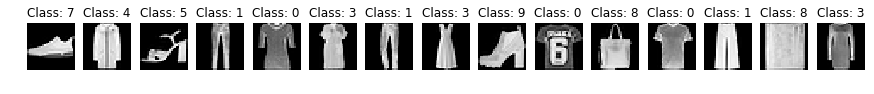

In [6]:
pltsize=1
plt.figure(figsize=(15*pltsize, pltsize))

for i in range(15):
    plt.subplot(1,15,i+1)
    plt.axis('off')
    plt.imshow(X_train[i,:,:,:].numpy().reshape(28,28), cmap="gray")
    plt.title('Class: '+str(y_train[i].item()))

Из класса модели убраны регуляризаторы BatchNorm и Dropout. L2 оставлен нулевым. Также увеличен learning rate.

In [8]:
class Net(nn.Module):
    def __init__(self, lr=1e-3, l2=0.):
        super(Net, self).__init__()
        self.fc1 = nn.Linear(28*28, 128)
        self.fc2 = nn.Linear(128, 128)
        self.fc3 = nn.Linear(128, 10)
        self.optim = optim.Adam(self.parameters(), lr=lr, weight_decay=l2)
        
    def forward(self, x):
        x = x.view(-1, 28*28)
        x = torch.tanh(self.fc1(x))
        x = torch.tanh(self.fc2(x))
        x = self.fc3(x)
        x = torch.log_softmax(x, dim=1)
        return x
    
    def loss(self, output, target, **kwargs):
        self._loss = F.nll_loss(output, target, **kwargs)
        return self._loss

In [9]:
def train(epoch, model):
    train_size = len(train_loader.sampler)
    for batch_idx, (data, target) in enumerate(train_loader):
        model.optim.zero_grad()
        output = model(data)
        loss = model.loss(output, target)
        loss.backward()
        model.optim.step()
            
        if batch_idx % 200 == 0:
            line = 'Train Epoch: {} [{}/{} ({:.0f}%)]\tLosses '.format(
                epoch, batch_idx * len(data), train_size, 100. * batch_idx / len(train_loader))
            losses = '{:.6f}'.format(model._loss.item())
            print(line + losses)
            
    else:
        batch_idx += 1
        line = 'Train Epoch: {} [{}/{} ({:.0f}%)]\tLosses '.format(
            epoch, batch_idx * len(data), train_size, 100. * batch_idx / len(train_loader))
        losses = '{:.6f}'.format(model._loss.item())
        print(line + losses)

In [10]:
model = Net()
train_log = []
test_log = []

In [11]:
def test(model, subset="Train", log=None):
    if subset == "Train":
        loader = train_loader
    else:
        loader = valid_loader
    test_size = len(loader.sampler)
    avg_lambda = lambda l: 'Loss: {:.4f}'.format(l)
    acc_lambda = lambda c, p: 'Accuracy: {}/{} ({:.0f}%)'.format(c, test_size, p)
    line = lambda l, c, p: avg_lambda(l) + '\t' + acc_lambda(c, p)

    test_loss = 0.
    correct = 0.
    with torch.no_grad():
        for data, target in loader:            
            output = model(data)
            test_loss += model.loss(output, target, reduction='sum').item() # sum up batch loss
            pred = output.data.max(1, keepdim=True)[1] # get the index of the max log-probability
            correct += pred.eq(target.data.view_as(pred)).cpu().sum().item()
    
    
    test_loss /= test_size
    correct_pct = 100. * correct / test_size
    lines = line(test_loss, correct, correct_pct) + '\n'
    report = subset + ' set:\n' + lines
    if log is not None:
        log.append((test_loss, correct_pct))
    print(report)

Обучение модели в течение 100 эпох.

In [12]:
for epoch in range(1, 101):
    model.train()
    train(epoch, model)
    model.eval()
    test(model, log=train_log)
    test(model, subset="Test", log=test_log)

Train Epoch: 1 [0/30000 (0%)]	Losses 2.316045
Train Epoch: 1 [10000/30000 (33%)]	Losses 0.543389
Train Epoch: 1 [20000/30000 (67%)]	Losses 0.378763
Train Epoch: 1 [30000/30000 (100%)]	Losses 0.443391
Train set:
Loss: 0.4047	Accuracy: 25550.0/30000 (85%)

Test set:
Loss: 0.4178	Accuracy: 25530.0/30000 (85%)

Train Epoch: 2 [0/30000 (0%)]	Losses 0.553600
Train Epoch: 2 [10000/30000 (33%)]	Losses 0.448818
Train Epoch: 2 [20000/30000 (67%)]	Losses 0.453253
Train Epoch: 2 [30000/30000 (100%)]	Losses 0.249865
Train set:
Loss: 0.3574	Accuracy: 26025.0/30000 (87%)

Test set:
Loss: 0.3943	Accuracy: 25721.0/30000 (86%)

Train Epoch: 3 [0/30000 (0%)]	Losses 0.397336
Train Epoch: 3 [10000/30000 (33%)]	Losses 0.349257
Train Epoch: 3 [20000/30000 (67%)]	Losses 0.404470
Train Epoch: 3 [30000/30000 (100%)]	Losses 0.268473
Train set:
Loss: 0.3283	Accuracy: 26322.0/30000 (88%)

Test set:
Loss: 0.3701	Accuracy: 25931.0/30000 (86%)

Train Epoch: 4 [0/30000 (0%)]	Losses 0.400240
Train Epoch: 4 [10000/30000

Train Epoch: 53 [20000/30000 (67%)]	Losses 0.093648
Train Epoch: 53 [30000/30000 (100%)]	Losses 0.031840
Train set:
Loss: 0.0785	Accuracy: 29184.0/30000 (97%)

Test set:
Loss: 0.4922	Accuracy: 26366.0/30000 (88%)

Train Epoch: 54 [0/30000 (0%)]	Losses 0.072010
Train Epoch: 54 [10000/30000 (33%)]	Losses 0.229627
Train Epoch: 54 [20000/30000 (67%)]	Losses 0.186799
Train Epoch: 54 [30000/30000 (100%)]	Losses 0.064427
Train set:
Loss: 0.0943	Accuracy: 28974.0/30000 (97%)

Test set:
Loss: 0.5156	Accuracy: 26267.0/30000 (88%)

Train Epoch: 55 [0/30000 (0%)]	Losses 0.116513
Train Epoch: 55 [10000/30000 (33%)]	Losses 0.135938
Train Epoch: 55 [20000/30000 (67%)]	Losses 0.085746
Train Epoch: 55 [30000/30000 (100%)]	Losses 0.071292
Train set:
Loss: 0.1060	Accuracy: 28811.0/30000 (96%)

Test set:
Loss: 0.5331	Accuracy: 26159.0/30000 (87%)

Train Epoch: 56 [0/30000 (0%)]	Losses 0.035203
Train Epoch: 56 [10000/30000 (33%)]	Losses 0.134117
Train Epoch: 56 [20000/30000 (67%)]	Losses 0.159760
Train Epo

На графике функции потерь можно видеть, что переобучаться модель начала примерно после десятой эпохи (Величина loss продолжала снижаться для обучающего множества, но начала расти на проверочном). 

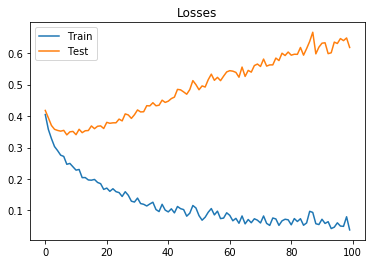

In [13]:
plt.title("Losses")
plt.plot(np.array(train_log)[:,0], label="Train")
plt.plot(np.array(test_log)[:,0], label="Test")
plt.legend()
plt.show()

Accuracy на проверочном множестве в это время достигла своего максимума и продолжила колебаться вокруг него, продолжая расти на тренировочном.

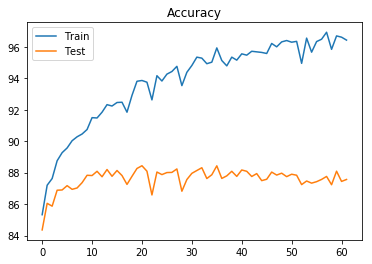

In [20]:
plt.title("Accuracy")
plt.plot(np.array(train_log)[:,1], label="Train")
plt.plot(np.array(test_log)[:,1], label="Test")
plt.legend()
plt.show()